# MNIST + MLP

In this notebook, we design and train a Multi-Layer Perceptrons (MLP) for hand-written digit classification task. We use MNIST dataset that contains 28x28 pixel images of a hand-written digit (0 to 9, so 10 classification targets). 

## Goals
1. Get familiar with MNIST dataset
2. Build a pipeline to stream data for SGD
3. Design MLP and train on MNIST

Let's start with usual import!

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device(device)
import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## 1. MNIST Dataset
MNIST is widely used for an introductory machine learning (ML) courses/lectures. Most, if not all, ML libraries provide an easy way (API) to access MNIST and many publicly available dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

A `torchvision` is a supporting module that has many image-related APIs including an interface (and management) of MNIST dataset. Let's see how we can construct:

In [2]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Use prepared data handler from pytorch (torchvision)
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

Here, MNIST is also a type `Dataset` (how? through class inheritance). All torch `Dataset` instance have tow useful and common functions: the length representations and data element access via index.

In [3]:
print( len(dataset)  )
print( type(dataset[0]) )

60000
<class 'tuple'>


That being said, how each data element is presented depends on a particular `Dataset` implementation. In case of MNIST, it is a tuple of length 2: **data** and **label**.

Type of data  : <class 'torch.Tensor'> shape torch.Size([1, 28, 28])
Type of label : <class 'int'> value 5


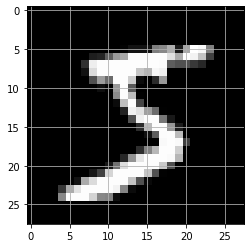

In [4]:
ENTRY=0
data, label = dataset[ENTRY]
print('Type of data  :', type(data),  'shape', data.shape)
print('Type of label :', type(label), 'value', label)

import matplotlib.pyplot as plt
%matplotlib inline

# Draw data
data = data.view(data.shape[1:])
plt.imshow(data,cmap='gray')
plt.show()

<a href="dataloader"></a>
## 2. Streaming MNIST data using `DataLoader`

Pytorch (and any other ML libraries out there) provides a generalized tool to interface an iteratable data instance called `DataLoader`. This is a useful tool for streaming data in a typical ML workflow. 

1. iteratable batching of data
2. custom data sampling (random provided by default)
3. custom data pre-processing
4. prallel data reading

Let's play a little bit.

In [5]:
from torch.utils.data import DataLoader

data = np.arange(10)

print('\nVanilla data loader')
loader = DataLoader(data)
for index, batch_data in enumerate(loader):
    print(index,batch_data)

print('\n... batch_size set to 3')
loader = DataLoader(data, batch_size=3)
for index, batch_data in enumerate(loader):
    print(index,batch_data)
    
print('\n... + drop_last set to True')
loader = DataLoader(data, batch_size=3, drop_last=True)
for index, batch_data in enumerate(loader):
    print(index,batch_data)

print('\n... + shuffle set to True')
loader = DataLoader(data, batch_size=3, drop_last=True, shuffle=True)
for index, batch_data in enumerate(loader):
    print(index,batch_data)


Vanilla data loader
0 tensor([0])
1 tensor([1])
2 tensor([2])
3 tensor([3])
4 tensor([4])
5 tensor([5])
6 tensor([6])
7 tensor([7])
8 tensor([8])
9 tensor([9])

... batch_size set to 3
0 tensor([0, 1, 2])
1 tensor([3, 4, 5])
2 tensor([6, 7, 8])
3 tensor([9])

... + drop_last set to True
0 tensor([0, 1, 2])
1 tensor([3, 4, 5])
2 tensor([6, 7, 8])

... + shuffle set to True
0 tensor([7, 3, 2])
1 tensor([6, 1, 0])
2 tensor([5, 9, 4])


We can wrap the data loading loop by another loop so that we can continue iterating our dataset indefinitely for optimizing our model over 1 epoch. But if you want a reproducibility of the data subsets created by `DataLoader`, you can set the random seed explicitly as well.

In [6]:
loader = DataLoader(data, batch_size=3, drop_last=True, shuffle=True)

for i in range(2):
    print('Loop',i)
    for index, batch_data in enumerate(loader):
        print(index,batch_data)
    
print('\nRepeating by setting the seed')
for i in range(2):
    print('Loop',i)
    torch.manual_seed(1)
    for index, batch_data in enumerate(loader):
        print(index,batch_data)

Loop 0
0 tensor([9, 0, 5])
1 tensor([1, 6, 7])
2 tensor([2, 3, 4])
Loop 1
0 tensor([3, 5, 7])
1 tensor([4, 1, 6])
2 tensor([2, 9, 0])

Repeating by setting the seed
Loop 0
0 tensor([4, 2, 0])
1 tensor([6, 8, 7])
2 tensor([9, 1, 5])
Loop 1
0 tensor([4, 2, 0])
1 tensor([6, 8, 7])
2 tensor([9, 1, 5])


### 2.1 Creating your own dataset

For your research, often we want to create our own dataset with handy utilities. You can define your own dataset and use with the `DataLoader` as long as it's either iterable (i.e. implements `__iter__` built-in method) or supports `len` function and a random index access (i.e. `__len__` and `__getitem__` support).

Let's create a trivial example:

In [7]:
import time

class toy_dataset:
    
    def __init__(self):
        self._data = tuple(range(100))
        
    def __len__(self):
        return len(self._data)
    
    def __getitem__(self,index):
        time.sleep(0.1)
        return self._data[index]
    
data = toy_dataset()

loader = DataLoader(data,batch_size=10,shuffle=True)

for index, batch_data in enumerate(loader):
    print(index,batch_data)

0 tensor([24, 89, 58, 31, 46, 33, 92,  6, 59, 86])
1 tensor([73, 20, 55, 14, 23, 84, 29, 49, 77, 70])
2 tensor([26, 54,  1, 56, 98, 90, 45, 93, 71, 13])
3 tensor([ 8, 94, 34, 18, 63, 22, 64, 75, 44, 57])
4 tensor([38, 96, 79, 60, 19, 80, 25, 37, 72, 41])
5 tensor([ 9,  5, 27, 32, 95,  2, 81,  0, 51, 28])
6 tensor([ 3, 35, 76, 36,  4, 48, 68, 11, 42, 99])
7 tensor([67, 47, 10, 17, 16, 15, 52, 97, 88, 87])
8 tensor([69, 21, 30, 74, 66, 83, 82, 62, 78, 39])
9 tensor([65, 43, 91, 40, 50, 61,  7, 85, 12, 53])


... which is very slow because our dataset takes 0.1 second per data element access :( While we put `time.sleep(0.1)` intentionally, this (=slow-down for per-sample data yield) can happen in reality. Perhaps you are forced to read each data sample from a file-system (i.e. "disk") each time because your data is too big to be stored in memory, or maybe you have to pre-process your data with complicated procedures. 

There is a simple way to automatize this by setting another `DataLoader` constructor argument: `num_workers`.

In [8]:
loader = DataLoader(data,batch_size=10,shuffle=True,num_workers=5)

for index, batch_data in enumerate(loader):
    print(index,batch_data)

0 tensor([95, 71, 31, 39, 54, 24, 11, 14, 61, 21])
1 tensor([73, 60, 32,  6, 47, 81, 15, 63, 17, 13])
2 tensor([62, 99, 35, 70, 41, 53, 72, 57, 28, 65])
3 tensor([91, 76, 51, 30, 49,  1, 23, 59, 42, 82])
4 tensor([86, 50,  3, 94, 96, 40, 26, 36, 52, 69])
5 tensor([66, 18, 33,  7, 27, 87, 88,  9, 25, 90])
6 tensor([38, 67, 93, 45, 89, 92, 84, 44, 19, 79])
7 tensor([ 2, 58, 56, 46, 97, 10,  0, 29, 78, 83])
8 tensor([74, 37, 68, 55,  4, 20, 48, 80, 85, 98])
9 tensor([ 8,  5, 34, 77, 64, 16, 12, 75, 43, 22])


By setting `num_workers=5`, we told `DataLoader` to use 5 separate _workers_ responsible for fetching data in parallel. This is one of the simplest forms to parallelize your data streaming.  In this tutorial, we don't cover a multi-GPU nor multi-node-multi-GPU data distribution. But tools are provided for those as well (e.g. Pytorch provides `DistributeDataParallel`, and there are also external wrapper tools like `Horovod`). 

### 2.2 Creating `DataLoader` with the MNIST dataset

Now let's create MNIST dataset with `batch_size=32`, `shuffle=True`, `num_workers=4`:

In [9]:
#from kmi.iotools.collates import MNISTCollate

loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=32,
                                     shuffle=True,
                                     num_workers=4,
                                     pin_memory=False)


The above introduced only 1 additional argument: `pin_memory=True` can speed up data transfer to GPU by avoiding a necessiry to copy data from pageable memory to page-locked (pinned) memory. Read [here](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/) for more details. If you are not sure about the details, set to `True` when using GPU. 

So let's play with it! First of all, it has the concept of "length".

In [10]:
print('length of DataLoader:',len(loader))
print('By the way, batch size * length =', 20 * len(loader))

length of DataLoader: 1875
By the way, batch size * length = 37500


We know the data total statistics is 60,000 which coincides with the length of `DataLoader` instance and the batch size where the latter is the unit of batch data.

In [11]:
# Create an iterator for playin in this notebook
from itertools import cycle
iter = cycle(loader)

for i in range(10):
    batch = next(iter)    
    print('Iteration',i)
    print(batch[1])

Iteration 0
tensor([9, 4, 5, 8, 2, 2, 1, 3, 4, 4, 4, 4, 6, 2, 1, 4, 1, 4, 9, 1, 6, 3, 6, 4,
        6, 1, 4, 6, 2, 3, 1, 4])
Iteration 1
tensor([0, 2, 8, 4, 5, 7, 9, 6, 3, 6, 7, 6, 3, 8, 0, 4, 8, 0, 8, 6, 6, 1, 4, 7,
        2, 2, 1, 5, 7, 4, 1, 3])
Iteration 2
tensor([7, 8, 4, 4, 8, 7, 4, 5, 3, 5, 6, 8, 4, 3, 9, 6, 8, 6, 4, 2, 9, 4, 3, 8,
        1, 1, 3, 5, 4, 6, 5, 0])
Iteration 3
tensor([8, 3, 0, 4, 5, 4, 3, 3, 9, 6, 3, 8, 9, 1, 8, 4, 3, 5, 9, 0, 1, 4, 2, 0,
        2, 0, 8, 0, 6, 2, 2, 2])
Iteration 4
tensor([9, 0, 7, 2, 4, 4, 2, 8, 6, 0, 1, 1, 0, 4, 6, 9, 8, 5, 3, 5, 3, 3, 1, 8,
        2, 8, 2, 9, 9, 5, 8, 3])
Iteration 5
tensor([6, 3, 8, 9, 7, 1, 3, 9, 1, 1, 5, 2, 9, 3, 7, 8, 2, 3, 9, 1, 5, 4, 8, 2,
        4, 0, 9, 5, 6, 6, 1, 8])
Iteration 6
tensor([6, 1, 5, 2, 5, 9, 4, 4, 2, 5, 0, 3, 1, 3, 8, 6, 3, 7, 8, 7, 1, 2, 6, 8,
        2, 4, 7, 7, 9, 1, 1, 2])
Iteration 7
tensor([8, 1, 5, 7, 0, 9, 8, 5, 8, 1, 6, 0, 0, 6, 2, 9, 9, 5, 8, 7, 7, 1, 9, 1,
        9, 2, 0, 2, 9, 9, 1, 0])


... and this is how `data` looks like:

In [12]:
print('Shape of an image batch data',batch[0].shape)

Shape of an image batch data torch.Size([32, 1, 28, 28])


... which is quite naturally 20 of 28x28 image

## 3. MNIST classification using MLP

Let's try classifying 10 hand-written digits using MLP!

### 3.1 Model definition
We follow a similar approach we have taken in the previous notebook where we tried a logistic regression using 2-layers MLP with LeakyReLU activation function between two layers.  


In [13]:
class MLP(torch.nn.Module):
    def __init__(self, num_filters=16):
        
        super(MLP, self).__init__()
        # MLP w/ 2 hidden layers, 128 neurons each
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(28*28, num_filters), 
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_filters,10)
        )

    def forward(self, x):
        # Make 2d image into 1D array
        x_1d = x.view(-1, np.prod(x.size()[1:]))
        return self._classifier(x_1d)


### 3.2 Train loop function
Next, let's define a train loop function. This is also mostly copy-and-paste from the previous notebook. A small modification include an option to specify gpu v.s. cpu mode.

In [14]:
from ipywidgets import IntProgress
from IPython.display import display

def train_torch(data_loader, model, num_iterations=100, lr=0.001, optimizer='SGD', device=None):
    # Create a Binary-Cross-Entropy (BCE) loss module
    criterion = torch.nn.CrossEntropyLoss()
    # Create an optimizer
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    # Progress bar for impatient me
    f = IntProgress(min=0,max=int(num_iterations/100),bar_style='info')
    display(f)
    # Now we run the training!
    loss_v=[]
    while num_iterations > 0:
        for data,label in data_loader:
            
            if device:
                data,label = data.to(device),label.to(device)
            # Prediction
            prediction = model(data)
            # Compute loss
            loss = criterion(prediction, label)
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Record loss
            loss_v.append(loss.item())
            # Update the progress bar
            if num_iterations%100 == 0:
                f.value += 1
            # Brake if we consumed all iteration counts
            num_iterations -= 1
            if num_iterations < 1:
                break
        
    return np.array(loss_v)

### Train!

Let's train for 4000 steps using Adam optimizer. Also, the number of filters is default = 16.

IntProgress(value=0, bar_style='info', max=40)

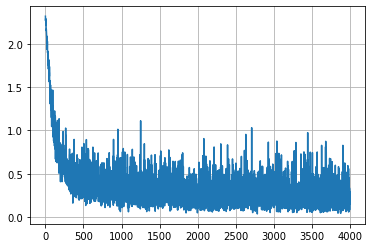

In [15]:
model_a = MLP()

loss = train_torch(loader, model_a, 4000, optimizer='Adam')

plt.plot(loss)


That is a pretty large fluctuation! Often it's useful to look at a moothed loss curve by taking an average value with the neighbor data points. Let's try this.

In [16]:
# Compute moving average
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

last 20 average 0.24326239731162785


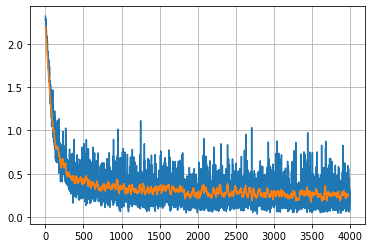

In [17]:
plt.plot(loss)
plt.plot(moving_average(loss,20))
print('last 20 average',np.mean(loss[-20:]))

### 3.3 Exercise A

1. Repeat the same training for `model_b` = `MLP` with 32 filters. 
2. Plot the loss curve with 20 neighbor-points average.
3. Compare the los value of the last 20 steps against the `model_a`. 

IntProgress(value=0, bar_style='info', max=40)

last 20 average 0.23727106163278222


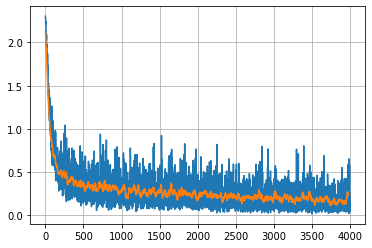

In [18]:
model_b = MLP(32)

loss = train_torch(loader, model_b, 4000, optimizer='Adam')

plt.plot(loss)
plt.plot(moving_average(loss,20))

print('last 20 average',np.mean(loss[-20:]))

### 3.4 Exercise B

1. Repeat the exercise 1 and measure how long it takes in wall-time.
2. Repeat again, but this time with GPU enabled, and measure how long it takes.

You probably see a very similar amount of time taken for both cases. This is because parallelizable fraction of computation is not dominating in the overall computing time (and especially when most time may be taken to copy data onto gpu).

In [19]:
import time

tstart=time.time()
model_b = MLP(32).to(device)
loss = train_torch(loader, model_b, 4000, optimizer='Adam',device=device)
print('With',device,time.time()-tstart)

tstart=time.time()
model_b = MLP(32).to('cpu')
loss = train_torch(loader, model_b, 4000, optimizer='Adam',device='cpu')
print('With cpu',time.time()-tstart)

IntProgress(value=0, bar_style='info', max=40)

With cuda 12.549604654312134


IntProgress(value=0, bar_style='info', max=40)

With cpu 7.5706000328063965


### Running on test dataset
Both models seem to be trained OK. Let's benchmark their performance using the test dataset! Pytorch provides 10,000 MNIST dataset that is separate from the training set by simply setting the flag `train=False`.

In [20]:
# Use prepared data handler from pytorch (torchvision)
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4,
                                          pin_memory=False)

### Inference loop function

Let's now write a function to run the inference. This would be similar to the training loop. A key difference is to use a scope `with torch.set_grad_enabled(False)` which disables gradient calculation and caching of intermediate data for it. This results in less memory usage, so you should do this when you run your model for inference and not training.

In [21]:
def run_test(model,loader,device):

    from scipy.special import softmax

    prediction_v = []
    label_v      = []
    softmax_v    = []
    
    with torch.set_grad_enabled(False):
        idx=0
        for data,label in loader:
            if gpu:
                data,label = data.to(device), label.to(device)
            prediction   = model(data).cpu().numpy()
            prediction_v.append ( np.argmax(prediction,axis=1)    )
            label_v.append      ( label.cpu().numpy().reshape(-1) )
            s = softmax(prediction,axis=1)
            softmax_v.append    (s)
            idx +=1
    return np.concatenate(prediction_v), np.concatenate(label_v), np.concatenate(softmax_v)

### 3.5 Exercise C
1. Run the inference for `model_a` and `model_b`.
2. Using the results, compute the accuracy over the whole test dataset for both models.

In [22]:

prediction, label, softmax = run_test(model_a,test_loader)

print('model_a',(prediction == label).sum() / len(label))

prediction, label, softmax = run_test(model_b,test_loader)

print('model_b',(prediction == label).sum() / len(label))

TypeError: run_test() missing 1 required positional argument: 'device'

### 3.6 Exercise D

1. Count the number of parameters in our `model_a`
2. How about `model_b`?


In [ ]:
print('model_a', 28*28*16 + 16 + 16*10 + 10, 'parameters')
print('model_b', 28*28*32 + 32 + 32*10 + 10, 'parameters')